<h1>Multivariate Time Series Forecasting with LSTMs in Keras</h1><br>
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


In [185]:
n_hours = 12
n_features = 8
n_outputs = 6
n_epochs = 30

In [186]:
from math import sqrt
from numpy import concatenate
import numpy as np
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [187]:
%%javascript
Jupyter.keyboard_manager.command_shortcuts.add_shortcut('r', {
    help : 'run all cells',
    help_index : 'zz',
    handler : function (event) {
        IPython.notebook.execute_all_cells();
        return false;
    }}
);

IPython.keyboard_manager.command_shortcuts.add_shortcut('alt-r',
  function (event) {
      IPython.notebook.kernel.restart();
      setTimeout(function(){ IPython.notebook.execute_all_cells(); }, 1000);
      return false;
});

<IPython.core.display.Javascript object>

In [188]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('../../input/beijing_air_pollution.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('../../input/pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


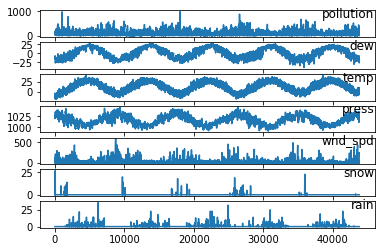

In [189]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('../../input/pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [190]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

<h3>Load Input</h3>

In [191]:
# load dataset
dataset = read_csv('../../input/pollution.csv', header=0, index_col=0)
values = dataset.values
print("data shape: ", values.shape)
print("data sample: \n", values[0:1,:])
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
print("data sample after LabelEncoder: \n",values[0:1,:])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print("data scaled: \n", scaled[0:1,:])

data shape:  (43800, 8)
data sample: 
 [[129.0 -16 -4.0 1020.0 'SE' 1.79 0 0]]
data sample after LabelEncoder: 
 [[129.0 -16 -4.0 1020.0 2 1.79 0 0]]
data scaled: 
 [[0.12977867 0.35294122 0.24590163 0.5272732  0.6666667  0.00229001
  0.         0.        ]]


<h3>Supervised Data Form</h3>

In [192]:
# specify the number of lag hours
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_outputs)
print("reframed shape: ", reframed.shape)
print("reframed sample \n ", reframed.head(1))

reframed shape:  (43783, 144)
reframed sample 
      var1(t-12)  var2(t-12)  var3(t-12)  var4(t-12)  var5(t-12)  var6(t-12)  \
12    0.129779    0.352941    0.245902    0.527273    0.666667     0.00229   

    var7(t-12)  var8(t-12)  var1(t-11)  var2(t-11)    ...      var7(t+4)  \
12         0.0         0.0    0.148893    0.367647    ...            0.0   

    var8(t+4)  var1(t+5)  var2(t+5)  var3(t+5)  var4(t+5)  var5(t+5)  \
12        0.0    0.16499   0.470588   0.229508   0.654547   0.666667   

    var6(t+5)  var7(t+5)  var8(t+5)  
12   0.066445        0.0        0.0  

[1 rows x 144 columns]


<h3>Tran and Test split</h3>

In [193]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
#print("train type: {}", type(train))
print("train shape: {}, test_shape: {}".format(train.shape, test.shape))


train shape: (8760, 144), test_shape: (35023, 144)


<h3>Train X, Y and Test X Y </h3>

In [194]:
# a = np.arange(160).reshape(10,16)
#print(a)
def get_y(data, n_outputs, y_index):
    y_outputs = list()
    for i in range(n_outputs):
        index = y_index * i
        #print("index: ", index)
        y = data[:, index]
        y_outputs.append(y)
        #print(i)
    return y_outputs


In [195]:
# split into input and outputs
n_obs = n_hours * n_features
print("n_hours: {}, n_features: {}".format(n_hours, n_features))
y_index = 8
print("n_obs: ", n_obs)
train_X = train[:, :n_obs]
train_y = get_y(train[:,n_obs:], n_outputs, y_index)
train_y = np.array(train_y).T
test_X = test[:, :n_obs]
test_y = get_y(test[:,n_obs:], n_outputs, y_index)
test_y = np.array(test_y).T

print("Train shape X: {} Y: {}".format(train_X.shape, train_y.shape))
print("Test shape X: {} Y: {}".format(test_X.shape, test_y.shape))

n_hours: 12, n_features: 8
n_obs:  96
Train shape X: (8760, 96) Y: (8760, 6)
Test shape X: (35023, 96) Y: (35023, 6)


In [196]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print("3D train X shape: {}, test X shape{}".format(train_X.shape, test_X.shape))

3D train X shape: (8760, 12, 8), test X shape(35023, 12, 8)


<h4>Training with Multiple Steps</h4>

Train on 8760 samples, validate on 35023 samples
Epoch 1/30
 - 5s - loss: 0.0624 - val_loss: 0.0687
Epoch 2/30
 - 3s - loss: 0.0432 - val_loss: 0.0609
Epoch 3/30
 - 3s - loss: 0.0391 - val_loss: 0.0526
Epoch 4/30
 - 4s - loss: 0.0371 - val_loss: 0.0495
Epoch 5/30
 - 4s - loss: 0.0357 - val_loss: 0.0468
Epoch 6/30
 - 3s - loss: 0.0346 - val_loss: 0.0455
Epoch 7/30
 - 3s - loss: 0.0338 - val_loss: 0.0450
Epoch 8/30
 - 3s - loss: 0.0331 - val_loss: 0.0443
Epoch 9/30
 - 3s - loss: 0.0324 - val_loss: 0.0441
Epoch 10/30
 - 4s - loss: 0.0318 - val_loss: 0.0434
Epoch 11/30
 - 4s - loss: 0.0313 - val_loss: 0.0430
Epoch 12/30
 - 4s - loss: 0.0308 - val_loss: 0.0427
Epoch 13/30
 - 4s - loss: 0.0305 - val_loss: 0.0420
Epoch 14/30
 - 3s - loss: 0.0302 - val_loss: 0.0415
Epoch 15/30
 - 3s - loss: 0.0300 - val_loss: 0.0413
Epoch 16/30
 - 3s - loss: 0.0297 - val_loss: 0.0408
Epoch 17/30
 - 3s - loss: 0.0296 - val_loss: 0.0404
Epoch 18/30
 - 3s - loss: 0.0294 - val_loss: 0.0400
Epoch 19/30
 - 3s - loss

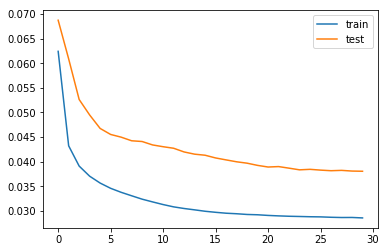

In [197]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(n_outputs))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

<h3>Prediction</h3>

In [198]:
def get_inv_y(y, x_features, scaler):
    y_x_features = concatenate((y, x_features), axis=1)
    inv_y_x_features = scaler.inverse_transform(y_x_features)
    inv_y = inv_y_x_features[:,0]
    return inv_y


In [199]:
def compute_rmse(yhat, test_y, x_features, scaler):
    #print("yhat: {}, x_features: {}".format(yhat.shape, x_features.shape))
    inv_yhat = get_inv_y(yhat, x_features, scaler)
    inv_y = get_inv_y(test_y, x_features, scaler)
    #print("inv_y: {}".format(inv_y))
    # calculate RMSE
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)## Test RMSE: 26.303    
    return rmse

def compute_all_rmse(yhat, test_y, test_X, scaler):
    
    list_rmse = list()
    test_X1 = test_X.reshape((test_X.shape[0], n_hours*n_features))
    x_features = test_X1[:,1:8]
    #print("x_features shape: ", x_features.shape)
        
    for i in range(yhat.shape[1]):
        print(i)
        yhat_item = yhat[:,i]
        yhat_item = yhat_item.reshape((len(yhat_item), 1))
        test_y_item = test_y[:,i]
        test_y_item = test_y_item.reshape((len(test_y_item), 1))        
        rmse = compute_rmse(yhat_item, test_y_item, x_features, scaler)
        list_rmse.append(rmse)

    return list_rmse

In [200]:
yhat = model.predict(test_X)

list_rmse = compute_all_rmse(yhat, test_y, test_X, scaler)  
print("all rmse: {}".format(list_rmse))


0
Test RMSE: 26.657
1
Test RMSE: 41.948
2
Test RMSE: 51.278
3
Test RMSE: 60.204
4
Test RMSE: 71.382
5
Test RMSE: 80.312
all rmse: [26.65689111186824, 41.94812732104006, 51.27806967591019, 60.20434765498668, 71.38195702740644, 80.31163970842738]
